#  Face Recognition

    CNN is trained on augmented AT&T dataset. 
    
    CNN Architecture: conv layer 1 = 300 neurons, conv layer 2 = 300 neurons, fully connected layer = 300 neurons
    
    Results on test set:    
                   Precision   Recall      F1
                    0.76      0.69      0.70
    

##  Import packages

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from time import time
import os

##  Prepare data

In [2]:
# Handle resizing of images, while maintaing aspect ratio
def resize_image(image, h, w):

    old_width = image.shape[1]
    old_height = image.shape[0]
    dH, dW = 0, 0
    
    if old_width < old_height:  #width is smaller, resize along width and compute new height
        aspect_r = w / old_width  #aspect ratio
        new_height = int(old_height * aspect_r)
        new_dim = (w, new_height)
        resized_img = cv2.resize(image, new_dim, interpolation = cv2.INTER_AREA)
        #dimensions of above image are: (new_height, desired_width). 
        #Since images in our dataset might be of diff. sizes, such resized images will end up being different sizes
        #hence crop the image as follows to make each image of size(desired_height, desired_width)
        dH = int((resized_img.shape[0] - h)/2.0)
        
    else:   #height is smaller, resize along height and compute new width
        aspect_r = h / old_height  #aspect ratio
        new_width = int(old_width * aspect_r)
        new_dim = (new_width, h)
        resized_img = cv2.resize(image, new_dim, interpolation = cv2.INTER_AREA)
        dW = int((resized_img.shape[1] - w)/2.0)
        
    new_h, new_w = resized_img.shape[:2]
    cropped_image = resized_img[dH:new_h - dH, dW:new_w - dW]  #dimensions of this image = desired dimensions
    #Make sure that the image is resized to desired dimensions
    return cv2.resize(cropped_image, (h, w), interpolation = cv2.INTER_AREA)  

#All images provided to the classifier should have fixed and equal sizes
dim = (64, 64)

print("Each image is resized to {}".format(dim))

Each image is resized to (64, 64)


In [4]:
#All images provided to the classifier should have fixed and equal sizes
dim = (64, 64)

def fetch_subject_images(path_to_subject, subject_number):
    X = np.array([])
    index = 0
    for subject_img in os.listdir(path_to_subject): #for each image in this subject's folder
        img_path = os.path.join(path_to_subject, subject_img)
        if img_path.endswith(".pgm") or img_path.endswith(".png") or img_path.endswith(".jpg") or img_path.endswith(".jpeg"):
            #Read image, convert it to grayscale and resize every image to a fixed size  
            img = cv2.resize(cv2.imread(img_path, 0), dim, interpolation = cv2.INTER_AREA) 
            
            img_data = img[np.newaxis, :, :]
            X = img_data if not X.shape[0] else np.vstack((X, img_data))
            index += 1

    y = np.empty(index, dtype = int) #index = total no. of samples
    y.fill(subject_number)  #add labels
    return X, y

def fetch_data(dataset_path):

    # Get a the list of folder names in the path to dataset
    labels_list = [d for d in os.listdir(dataset_path) if "." not in str(d)]

    X = np.empty([0, dim[0], dim[1]])
    y = np.empty([0])

    for i in range(0, len(labels_list)):  #for each person
        subject = str(labels_list[i])  #person i in list of ppl
        path_to_subject = os.path.join(dataset_path, subject) #full path to this person's directory
        
        #Read all images in this folder (all images of this person)
        X_, y_ = fetch_subject_images(path_to_subject, i)
        X = np.concatenate((X, X_), axis=0)
        y = np.append(y, y_)
        print("Subject {}, {} images loaded".format(i, X_.shape[0]))

    return X, y, labels_list

# Load training data 
dataset_path = "att_faces/"
X_face, y_face, labels_list  = fetch_data(dataset_path)

Subject 0, 10 images loaded
Subject 1, 10 images loaded
Subject 2, 10 images loaded
Subject 3, 10 images loaded
Subject 4, 10 images loaded
Subject 5, 10 images loaded
Subject 6, 10 images loaded
Subject 7, 10 images loaded
Subject 8, 10 images loaded
Subject 9, 10 images loaded
Subject 10, 10 images loaded
Subject 11, 10 images loaded
Subject 12, 10 images loaded
Subject 13, 10 images loaded
Subject 14, 10 images loaded
Subject 15, 10 images loaded
Subject 16, 10 images loaded
Subject 17, 10 images loaded
Subject 18, 10 images loaded
Subject 19, 10 images loaded
Subject 20, 10 images loaded
Subject 21, 10 images loaded
Subject 22, 10 images loaded
Subject 23, 10 images loaded
Subject 24, 10 images loaded
Subject 25, 10 images loaded
Subject 26, 10 images loaded
Subject 27, 10 images loaded
Subject 28, 10 images loaded
Subject 29, 10 images loaded
Subject 30, 10 images loaded
Subject 31, 10 images loaded
Subject 32, 10 images loaded
Subject 33, 10 images loaded
Subject 34, 10 images lo

In [8]:
import re
q = labels_list
def stringSplitByNumbers(x):
    r = re.compile('(\d+)')
    l = r.split(x)
    return [int(y) if y.isdigit() else y for y in l]

labels_list_faces = sorted(q, key = stringSplitByNumbers)

#  Augment data

In [5]:
def augment_data(dataset, dataset_labels, augementation_factor=1, use_random_rotation=True, use_random_shear=True, 
                 use_random_shift=True, use_random_zoom=True):
    augmented_image = []
    augmented_image_labels = []

    for num in range (0, dataset.shape[0]):
#         print("Sample {} is {} img".format(num, dataset[num].shape))
        # original image:
         #convert to (1, h, w) shape
        img_reshaped = np.array([dataset[num]])
#         print("New img shape", img_reshaped.shape)
        augmented_image.append(img_reshaped)
        augmented_image_labels.append(dataset_labels[num])

        if use_random_rotation:
            rotated_img= tf.keras.preprocessing.image.random_rotation(img_reshaped, 20, row_axis=1, col_axis=2, channel_axis=0)
#             print("rotated image",rotated_img.shape)
            augmented_image.append(rotated_img)  #(1, h, w)
            #image array should be 3D: n_channels, n_rows, n_cols
            augmented_image_labels.append(dataset_labels[num])
        
        if use_random_shear:
            rand_sheer_img = tf.keras.preprocessing.image.random_shear(img_reshaped, 0.2, row_axis=1, col_axis=2, channel_axis=0)
            augmented_image.append(rand_sheer_img)
            augmented_image_labels.append(dataset_labels[num])
            
        if use_random_shift:
            rand_shift_img = tf.keras.preprocessing.image.random_shift(img_reshaped, 0.2, 0.2, row_axis=1, col_axis=2, channel_axis=0)
            augmented_image.append(rand_shift_img)
            augmented_image_labels.append(dataset_labels[num])
            
        if use_random_zoom:
            zoomed_img = tf.keras.preprocessing.image.random_zoom(img_reshaped, (0.2,0.4) , row_axis=1, col_axis=2, channel_axis=0)
            augmented_image.append(zoomed_img)
            augmented_image_labels.append(dataset_labels[num])

                
    return np.array(augmented_image), np.array(augmented_image_labels)

print("Original data:", X_face.shape, y_face.shape)

X_aug, y_aug = augment_data(X_face, y_face) 
X_aug = np.squeeze(X_aug)   #squeeze:  remove single-dimensional entries from shape of  array
print("New data", X_aug.shape, ", labels", y_aug.shape)

Original data: (400, 64, 64) (400,)
New data (1600, 64, 64) , labels (1600,)


# Split into training and test sets

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

n_classes = len(np.unique(y_aug))
encoder = OneHotEncoder()
labels = encoder.fit_transform(np.reshape(y_aug, (-1, 1))).toarray()

print("Dataset consists of {} samples and  {} classes".format(X_aug.shape[0], n_classes))
print("Data: {} and labels: {}".format(X_aug.shape, labels.shape))                                                                                           
print(" ")
X_train, X_test, y_train, y_test = train_test_split(X_aug, labels, test_size=0.20, random_state=42)
print("Training data {}, test data {}".format(X_train.shape, X_test.shape))

Dataset consists of 1600 samples and  40 classes
Data: (1600, 64, 64) and labels: (1600, 40)
 
Training data (1280, 64, 64), test data (320, 64, 64)


#  CNN 

In [10]:
width = 64
height = 64

n_features = height*width
channels = 1

feature_map1 = 300
ksize_conv1 = 2
stride_conv1 = 1

feature_map2 = 300
ksize_conv2 = ksize_conv1
stride_conv2 = stride_conv1

pool_layer_maps2 = feature_map2

n_fully_conn1 = 300
  
X = tf.placeholder(tf.float32, shape=[None, height, width])
X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
y = tf.placeholder(tf.int32, shape=[None, n_classes])

xavier_init = tf.contrib.layers.xavier_initializer()
relu_act = tf.nn.relu

# ------------------ Convolutional and pooling layers ----------------------------

def convolutional_layer(X, filter_, ksize, kernel_init, strides, padding):
    convolutional_layer = tf.layers.conv2d(X, filters = filter_, kernel_initializer = kernel_init,
                                           kernel_size = ksize, strides = strides,
                                          padding = padding, activation = relu_act)
    return convolutional_layer

def pool_layer(convlayer, ksize, strides, padding, pool_maps):
    pool = tf.nn.max_pool(convlayer, ksize, strides, padding)
    dim1, dim2 = int(pool.get_shape()[1]), int(pool.get_shape()[2])
    pool_flat = tf.reshape(pool, shape = [-1, pool_maps * dim1 * dim2])
    return pool_flat

conv_layer1 = convolutional_layer(X_reshaped, feature_map1, ksize_conv1, xavier_init, stride_conv1, padding = "SAME")

conv_layer2 = convolutional_layer(conv_layer1, feature_map2, ksize_conv2, xavier_init, stride_conv2, padding = "SAME")

pool_layer2_flat = pool_layer(conv_layer2, [1,2,2,1], [1,2,2,1], "VALID", pool_layer_maps2)

# ----------------- Fully connected layer -------------------

def dense_layer(input_layer, n_neurons, kernel_init, activation):
    fully_conn = tf.layers.dense(inputs = input_layer, units = n_neurons, activation = activation,
                                kernel_initializer = kernel_init)
    return fully_conn
        
dense_layer1 = dense_layer(pool_layer2_flat, n_fully_conn1, xavier_init, relu_act)

#--------------------------------------------------------------

logits = tf.layers.dense(dense_layer1, n_classes)

prediction = tf.nn.softmax(logits)

xentropy = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer(0.001)
train_step = optimizer.minimize(loss)

correct_preds = tf.equal(tf.argmax(prediction,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

saver = tf.train.Saver()

n_epochs = 100
batch_size = 64
n_train = X_train.shape[0]
n_iter = n_train//batch_size
path = "./face_recCNN_aug1_again"

train_loss_log, train_acc_log, val_loss_log, val_acc_log = ([] for i in range (4))

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

#initialize variables for early stopping
min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20 

start = time()
for epoch in range(n_epochs):
    for iteration in range(n_iter):
        rand_indices = np.random.choice(n_train, batch_size, replace = False)    
        X_batch, y_batch = X_train[rand_indices], y_train[rand_indices]
        sess.run(train_step, feed_dict={X: X_batch, y: y_batch})
        
    train_loss, train_acc = sess.run([loss, accuracy], feed_dict={X: X_batch, y: y_batch})
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)

    val_loss, val_acc, y_pred = sess.run([loss, accuracy, prediction], feed_dict={X: X_test, y: y_test})
    val_loss_log.append(val_loss)
    val_acc_log.append(val_acc)
        
    # Early stopping 
        
    if val_loss < min_loss:
        save_path = saver.save(sess, path)
        min_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement > max_epochs_without_improvement:
            print("** EARLY STOPPING ** ")
            break
    print("EPOCH {}".format(epoch))
    print("Train accuracy = {}, train loss = {}".format(train_acc, train_loss))
    print("Validation loss: {}, minimum loss: {}, validation accuracy: {}".format(val_loss, min_loss, val_acc))
    print(" ")
    
print("Training took %f minutes"%(float(time() - start)/60.0))

saver.restore(sess, path)
acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
print("Final test accuracy = {}".format(acc_test))

y_predicted = logits.eval(feed_dict = {X : X_test})

EPOCH 0
Train accuracy = 0.828125, train loss = 1.0985342264175415
Validation loss: 2.5332610607147217, minimum loss: 2.5332610607147217, validation accuracy: 0.3812499940395355
 
EPOCH 1
Train accuracy = 0.890625, train loss = 0.6260462403297424
Validation loss: 2.100984573364258, minimum loss: 2.100984573364258, validation accuracy: 0.637499988079071
 
EPOCH 2
Train accuracy = 1.0, train loss = 0.10147459805011749
Validation loss: 1.8736355304718018, minimum loss: 1.8736355304718018, validation accuracy: 0.6312500238418579
 
EPOCH 3
Train accuracy = 0.953125, train loss = 0.22120465338230133
Validation loss: 2.051478385925293, minimum loss: 1.8736355304718018, validation accuracy: 0.6781250238418579
 
EPOCH 4
Train accuracy = 0.984375, train loss = 0.05560923367738724
Validation loss: 1.9996840953826904, minimum loss: 1.8736355304718018, validation accuracy: 0.699999988079071
 
EPOCH 5
Train accuracy = 1.0, train loss = 0.0022678396198898554
Validation loss: 1.983088731765747, minimu

##  Inspect learning curves

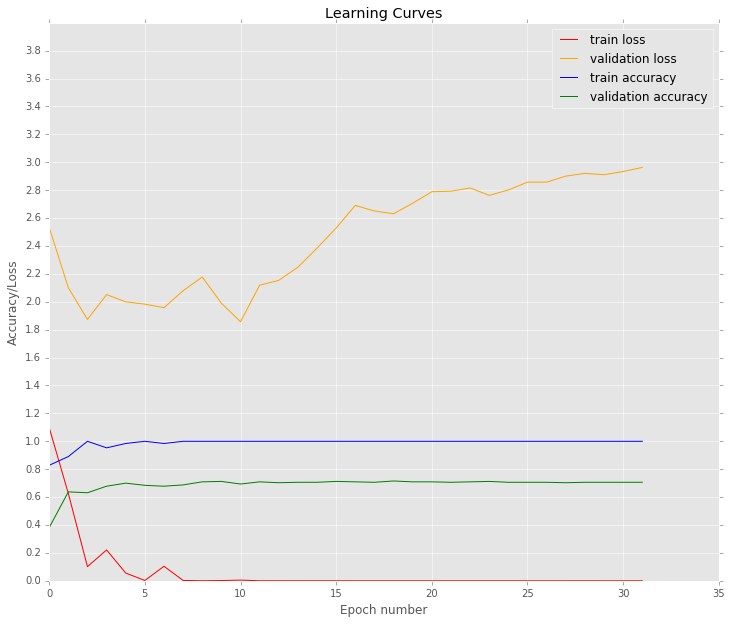

In [11]:
#plot the training + testing loss and accuracy
%matplotlib inline
plt.style.use("ggplot")
plt.figure()

num_epochs_trained = len(train_loss_log)
plt.plot(np.arange(0, num_epochs_trained), train_loss_log, label="train loss", c = "red")
plt.plot(np.arange(0, num_epochs_trained), val_loss_log, label="validation loss",c = "orange")
plt.plot(np.arange(0, num_epochs_trained), train_acc_log, label="train accuracy", c = "blue")
plt.plot(np.arange(0, num_epochs_trained), val_acc_log, label="validation accuracy", c = "green")

plt.title("Learning Curves")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy/Loss")
plt.ylim([0, 4])
plt.yticks(np.arange(0, 4, 0.2))

plt.legend()

plt.gcf().set_size_inches((12, 10))
plt.show()

## Classification report

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print("Classification report:")
print(classification_report(y_test.argmax(axis=1), y_predicted.argmax(axis=1), target_names = labels_list_faces))

Classification report:
             precision    recall  f1-score   support

         s1       0.62      1.00      0.77         5
         s2       1.00      0.57      0.73        14
         s3       1.00      0.67      0.80         6
         s4       0.83      1.00      0.91         5
         s5       1.00      0.55      0.71        11
         s6       0.33      0.33      0.33         6
         s7       0.78      0.64      0.70        11
         s8       0.73      0.89      0.80         9
         s9       1.00      0.64      0.78        11
        s10       0.75      0.55      0.63        11
        s11       1.00      0.67      0.80         9
        s12       1.00      0.67      0.80         6
        s13       0.83      0.71      0.77         7
        s14       0.90      0.69      0.78        13
        s15       0.79      0.92      0.85        12
        s16       0.39      0.64      0.48        11
        s17       0.60      0.60      0.60         5
        s18       1.00